# Sentiment Analysis using RNN and LSTM

This guide provides steps to perform sentiment analysis using Recurrent Neural Network (RNN) and Long Short-Term Memory (LSTM) models. We will preprocess the data, create and train the models, and build a simple GUI for sentiment prediction.


In [4]:
!pip install torch
!pip install tensorflow

In [6]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,TensorDataset
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<Figure size 1000x500 with 0 Axes>

# Setup Device to Use GPU

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [8]:
df = pd.read_csv('Data/amazon_reviews.csv')
df.head(10)

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0
5,positive,overall love this mouse the size weight clicki...,68,3.0
6,neutral,it stopped working,3,1.0
7,positive,my son uses school issued chromebook for schoo...,170,1.0
8,negative,loved this cute little mouse but it broke afte...,17,1.0
9,negative,should ve spent the money to get quality produ...,17,1.0


In [9]:
print(df.isna().sum())

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64


In [10]:
df=df.dropna()

In [11]:
print(df.isna().sum())

sentiments               0
cleaned_review           0
cleaned_review_length    0
review_score             0
dtype: int64


# Text Preprocessing

In [12]:
def text_preprocessing(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    tokens = word_tokenize(text.lower())  
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]  
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [18]:

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/litesh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/litesh/nltk_data...
[nltk_data] Downloading package stopwords to /home/litesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
df.loc[:, 'cleaned_review'] = df['cleaned_review'].apply(text_preprocessing)

In [20]:
df['cleaned_review']

0        wish would gotten one earlier love make workin...
1        learned lesson open package use product right ...
2                              slow lag find better option
3        roller ball stopped working within month minim...
4            like color size day return period hold charge
                               ...                        
17335    love speaker love take anywhere charge phone w...
17336              use house easy connect loud clear music
17337    bass good battery amazing much better charge t...
17338                                                 love
17339                                         mono speaker
Name: cleaned_review, Length: 17337, dtype: object

# Tokenization and Padding

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

In [22]:
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
labels = pd.get_dummies(df['sentiments']).values

# Train-Validation Split

In [23]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [24]:
train_data = TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).float())
val_data = TensorDataset(torch.from_numpy(X_val).long(), torch.from_numpy(y_val).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=50)
val_loader = DataLoader(val_data, shuffle=True, batch_size=50)

# Define RNN and LSTM Models

In [25]:
class RNN(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(RNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(len(tokenizer.word_index)+1, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.rnn(embedded)
        out = self.dropout(out)
        out = self.fc(out[:, -1])
        return out

In [26]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1])
        out = self.fc(lstm_out)
        return out


# Define Accuracy Function

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Initialize Models

In [28]:
# Initialize models
epochs = 20
output_size = 3
embedding_dim = 400
hidden_dim = 256
n_layers = 2
vocab_size = len(tokenizer.word_index) + 1

rnn_model = RNN(output_size, embedding_dim, hidden_dim, n_layers).to(device)
lstm_model = LSTM(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)

In [29]:
def print_model_summary(model, model_name):
    print(f"Model Summary for {model_name}")
    print(model)
    print("\n")

In [30]:
print_model_summary(rnn_model, "RNN")

Model Summary for RNN
RNN(
  (embedding): Embedding(8507, 400)
  (rnn): RNN(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)




In [31]:
print_model_summary(lstm_model, "LSTM")

Model Summary for LSTM
LSTM(
  (embedding): Embedding(8507, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)




# Define Optimizers and Loss Function

In [32]:
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training and Validation Function

In [33]:
def train_and_validate(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        # Training mode
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation mode
        model.eval()
        total_val_loss, total_acc = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                val_loss = criterion(output, torch.max(labels, 1)[1])
                total_val_loss += val_loss.item()
                acc = accuracy(output, torch.max(labels, 1)[1])
                total_acc += acc.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        avg_acc = total_acc / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_acc)

        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Val Acc: {avg_acc}')

    return train_losses, val_losses, val_accs


# Plotting Losses

In [34]:
def plot_losses(Model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {Model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Train Models

RNN Start Trianing: 

Epoch: 1/20, Train Loss: 0.6850368802924808, Val Loss: 0.8563929506710597, Val Acc: 0.5987936556339264
Epoch: 2/20, Train Loss: 0.6056377723705855, Val Loss: 0.5408081867865153, Val Acc: 0.7797460309096745
Epoch: 3/20, Train Loss: 0.460470894740211, Val Loss: 0.4773778327873775, Val Acc: 0.8208888862814222
Epoch: 4/20, Train Loss: 0.38515460351817044, Val Loss: 0.49911867954901284, Val Acc: 0.8118412630898612
Epoch: 5/20, Train Loss: 0.3369330833766529, Val Loss: 0.5014979498726981, Val Acc: 0.8233333281108312
Epoch: 6/20, Train Loss: 0.2906793189777745, Val Loss: 0.49137845976012096, Val Acc: 0.8391111033303397
Epoch: 7/20, Train Loss: 0.19495569653273057, Val Loss: 0.5020697197743824, Val Acc: 0.85492063164711
Epoch: 8/20, Train Loss: 0.23285404569971904, Val Loss: 0.6129184769732612, Val Acc: 0.7716825374535152
Epoch: 9/20, Train Loss: 0.22436900587631858, Val Loss: 0.5152012044829982, Val Acc: 0.8491111048630305
Epoch: 10/20, Train Loss: 0.12356655911388371, V

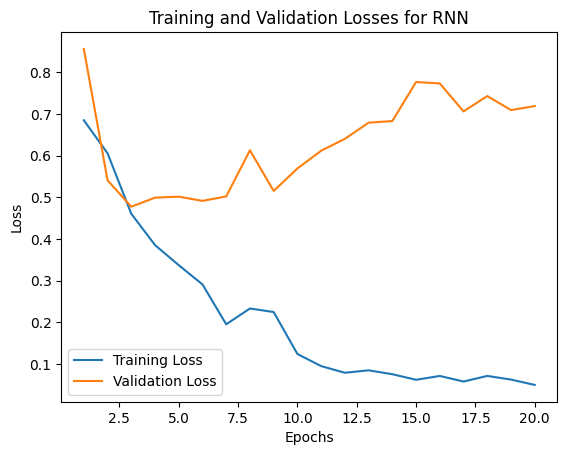

In [35]:
print("RNN Start Trianing: \n")
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(rnn_model, rnn_optimizer, criterion, train_loader, val_loader, epochs, device)
plot_losses("RNN",rnn_train_losses, rnn_val_losses, epochs)

LSTM Start Trianing: 

Epoch: 1/20, Train Loss: 0.5811562456672997, Val Loss: 0.4595613569021225, Val Acc: 0.8165714221341269
Epoch: 2/20, Train Loss: 0.36590461993067386, Val Loss: 0.40417258526597705, Val Acc: 0.8481904702527182
Epoch: 3/20, Train Loss: 0.24491099099353922, Val Loss: 0.4108265122132642, Val Acc: 0.85984126329422
Epoch: 4/20, Train Loss: 0.15449619068087433, Val Loss: 0.4299800191606794, Val Acc: 0.8754920601844788
Epoch: 5/20, Train Loss: 0.09386175335049897, Val Loss: 0.5011511963925191, Val Acc: 0.8776190408638546
Epoch: 6/20, Train Loss: 0.06920742765136009, Val Loss: 0.48412158973515035, Val Acc: 0.8750476147447314
Epoch: 7/20, Train Loss: 0.050035152838920516, Val Loss: 0.5440501767609801, Val Acc: 0.8799682455403465
Epoch: 8/20, Train Loss: 0.03731398534686338, Val Loss: 0.5793154599411147, Val Acc: 0.8890476150172097
Epoch: 9/20, Train Loss: 0.02599928990067586, Val Loss: 0.616728663817048, Val Acc: 0.8805396778242929
Epoch: 10/20, Train Loss: 0.02912055760879

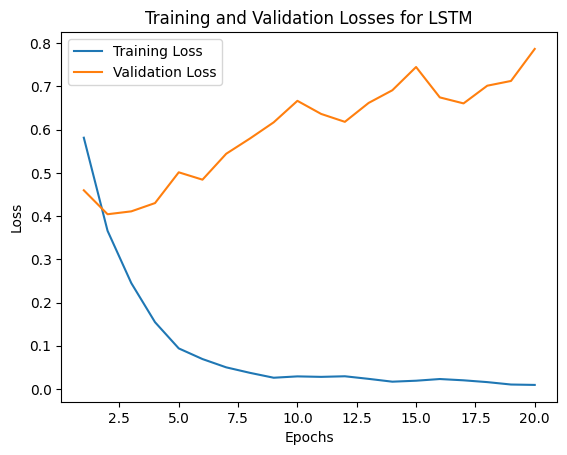

In [36]:
print("LSTM Start Trianing: \n")
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(lstm_model, lstm_optimizer, criterion, train_loader, val_loader, epochs, device)
plot_losses("LSTM",lstm_train_losses, lstm_val_losses, epochs)

# Build GUI for Sentiment Prediction

In [37]:
import tkinter as tk
from tkinter import simpledialog, messagebox

def predict_sentiment(model, review, tokenizer, max_len, device):
    review_cleaned = text_preprocessing(review)
    sequence = tokenizer.texts_to_sequences([review_cleaned])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    input_tensor = torch.from_numpy(padded_sequence).long().to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_map[predicted_index]

def on_predict():
    review = text_entry.get("1.0", "end-1c")
    if review.strip() == "":
        messagebox.showinfo("Prediction", "Please enter a review for prediction.")
    else:
        selected_model = model_var.get()
        if selected_model == 'RNN':
            model_to_use = rnn_model
        elif selected_model == 'LSTM':
            model_to_use = lstm_model
        predicted_sentiment = predict_sentiment(model_to_use, review, tokenizer, max_len, device)
        messagebox.showinfo("Prediction", f"The predicted sentiment of the review is: {predicted_sentiment}")
root = tk.Tk()
root.title("Sentiment Analysis of Reviews")
text_entry = tk.Text(root, height=10, width=50)
text_entry.pack(padx=10, pady=10)
model_var = tk.StringVar(value='LSTM') 
rnn_button = tk.Radiobutton(root, text="RNN", variable=model_var, value='RNN')
lstm_button = tk.Radiobutton(root, text="LSTM", variable=model_var, value='LSTM')
rnn_button.pack()
lstm_button.pack()
predict_button = tk.Button(root, text="Predict Sentiment", command=on_predict)
predict_button.pack(pady=10)
root.mainloop()